In [ ]:
pip install lime

In [ ]:
from IPython.display import Markdown, display

In [ ]:
import pandas as pd
import numpy as np
import nltk 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold 

import seaborn as sns
from collections import Counter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount = True

Mounted at /content/gdrive


# Read Data

In [ ]:
df = pd.read_pickle("./gdrive/MyDrive/IR_Lab/Datasets/final_features_combined.pkl")

In [ ]:
print(df.shape)

(61136, 494)


In [ ]:
# Remove non-numeric columns
non_numeric_cols = ['title', 'body', 'lang',
       'title_token', 'body_token', 'title_processed', 'body_processed', 'title_lemma','body_lemma',
        'label']
print("non-numeric cols",len(non_numeric_cols))
X = df.drop(non_numeric_cols, axis = 1)

title_columns = set(X.columns[X.columns.str.startswith('title')])
print('title cols',len(title_columns))
body_columns  = set(X.columns[X.columns.str.startswith('body')])
print('body cols',len(body_columns))

#print("Intersection of title and body cols",title_columns.intersection(body_columns))
#print("Union of title and body cols",title_columns.intersection(body_columns))
print("Total cols",len(df.columns))

non-numeric cols 10
title cols 241
body cols 243
Total cols 494


In [ ]:
print(df.label.value_counts())

# Sample the min of both Fake and Real i.e. Real
df_true = df[df.label == 1].sample(len(df[df.label == 0])) 
df_fake = df[df.label == 0].sample(len(df[df.label == 0]))
df_final = pd.DataFrame(np.concatenate([df_true, df_fake]), columns = df_true.columns)

print(df_final.label.value_counts())

1    33229
0    27907
Name: label, dtype: int64
1    27907
0    27907
Name: label, dtype: int64


# Differentiate Features

## Stylistic Features

-  Text statistics like word count,  words_per_sentence etc.
-  POS features

In [ ]:
title_pos_features = ["title_''",'title_CC','title_CD','title_DT','title_EX','title_FW','title_IN','title_JJ','title_JJR','title_JJS','title_MD','title_NN','title_NNP','title_NNPS','title_NNS',
 'title_PDT','title_POS','title_PRP','title_PRP$','title_RB','title_RBR','title_RBS','title_RP','title_SYM','title_TO','title_UH',
 'title_VB','title_VBD','title_VBG','title_VBN','title_VBP','title_VBZ','title_WDT','title_WP','title_WP$','title_WRB']

In [ ]:
title_text_statistics = ['title_length','title_sent_count','title_word_count']

In [ ]:
title_stylistic_features = list(set(title_pos_features).union(set(title_text_statistics)))

In [ ]:
body_pos_features = ['body_$',
 "body_''",
 'body_CC',
 'body_CD',
 'body_DT',
 'body_EX',
 'body_FW',
 'body_IN',
 'body_JJ',
 'body_JJR',
 'body_JJS',
 'body_MD',
 'body_NN',
 'body_NNP',
 'body_NNPS',
 'body_NNS',
 'body_PDT',
 'body_POS',
 'body_PRP',
 'body_PRP$',
 'body_RB',
 'body_RBR',
 'body_RBS',
 'body_RP',
 'body_SYM',
 'body_TO',
 'body_UH',
 'body_VB',
 'body_VBD',
 'body_VBG',
 'body_VBN',
 'body_VBP',
 'body_VBZ', 
 'body_WDT',
 'body_WP',
 'body_WP$',
 'body_WRB',
 'body_``']

In [ ]:
body_text_statistics = ['body_length','body_sent_count','body_word_count']

In [ ]:
body_stylistic_features =  list(set(body_pos_features).union(set(body_text_statistics)))

## Psychology features

- Sentiment analysis features from Vader, Textblob etc
- Emotion features from Empath

In [ ]:
title_sentiment_features  = ['title_compound_sentiment','title_polarity', 'title_subjectivity'] 
title_emotion_features = [col for col in title_columns if col.startswith('title_emo')]

In [ ]:
title_psychology_features = list(set(title_sentiment_features).union(set(title_emotion_features)))

In [ ]:
body_sentiment_features = ['body_polarity', 'body_subjectivity'] 
body_emotion_features = [col for col in body_columns if col.startswith('body_emo')]

In [ ]:
body_psychology_features = list(set(body_sentiment_features).union(set(body_emotion_features)))

## Complexity Features
-  Common readability measures
-  Type Token Ratio  (Not for title)
-  avg word len,  avg sentence len

In [ ]:
title_complexity_features = ['title_avg_sent_len', 'title_avg_word_len','title_flesch_kincaidgrade',
 'title_flesch_readability',
 'title_gunning_fog']

In [ ]:
body_complexity_features = ['body_avg_sent_len', 'body_avg_word_len','body_flesch_kincaidgrade',
 'body_flesch_readability',
 'body_gunning_fog','body_TTR']

SANITY CHECK FOR LENGTH OF ALL FEATURES

In [ ]:
print(len(title_complexity_features))
print(len(title_psychology_features))
print(len(title_stylistic_features))
print(len(title_columns),'==',5+197+39)

5
197
39
241 == 241


In [ ]:
print(len(body_complexity_features))
print(len(body_psychology_features))
print(len(body_stylistic_features))
print(len(body_columns),'==',6+196+41)

6
196
41
243 == 243


# Modelling

In [ ]:
def model_evaluate(X,y,classifier):
  # #############################################################################
  # Classification and ROC analysis

  # Run classifier with cross-validation and plot ROC curves
  cv = StratifiedKFold(n_splits=5)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  avgP = []
  avgR = []
  avgF = []

  clf_report = {}

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X.iloc[train], y.iloc[train])

      clf_report[i] = classification_report(y.iloc[test], classifier.predict(X.iloc[test]),target_names= ['Fake','Real'],output_dict = True)

      avgF.append(clf_report[i]['macro avg']['f1-score'])
      avgP.append(clf_report[i]['macro avg']['precision'])
      avgR.append(clf_report[i]['macro avg']['recall'])

      viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  print()
  print("Scores for "+str(classifier.__class__.__name__))
  print("F1:",np.mean(avgF, axis = 0),"+/-",np.std(avgF))
  print("P:",np.mean(avgP, axis = 0),"+/-",np.std(avgP))
  print("R:",np.mean(avgR, axis = 0),"+/-",np.std(avgR))

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)

  print("AUC:",mean_auc,"+/-",std_auc)

  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC for "+str(classifier.__class__.__name__))
  ax.legend(loc="lower right")
  plt.show()
  plt.pause(0.1)

  return clf_report

In [ ]:
import tensorflow as tf
from tensorflow import keras

def init_nn(input = input):
    model = keras.Sequential([

        keras.layers.Flatten(input_shape=(input,)),

        keras.layers.Dense(128, activation=tf.nn.relu),

        keras.layers.Dense(64, activation=tf.nn.relu),

        keras.layers.Dense(1, activation=tf.nn.sigmoid),

    ])

    model.compile(optimizer='adam',

                  loss='binary_crossentropy',

                  metrics=['accuracy'])
    
    return model

##  Title

### Stylistic

In [ ]:
X = df_final[title_stylistic_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
print(len(X.columns))
X.columns

39


Index(['title_WP$', 'title_VBZ', 'title_EX', 'title_RBS', 'title_JJ',
       'title_RB', 'title_JJR', 'title_UH', 'title_TO', 'title_POS',
       'title_NNPS', 'title_PDT', 'title_WP', 'title_VBP', 'title_NNP',
       'title_WRB', 'title_length', 'title_IN', 'title_FW', 'title_NNS',
       'title_VB', 'title_JJS', 'title_sent_count', 'title_CD', 'title_MD',
       'title_SYM', 'title_NN', 'title_PRP$', 'title_PRP', 'title_RP',
       'title_CC', 'title_''', 'title_RBR', 'title_WDT', 'title_VBD',
       'title_DT', 'title_VBN', 'title_VBG', 'title_word_count'],
      dtype='object')


Scores for AdaBoostClassifier
F1: 0.7332241003133719 +/- 0.003488591333045429
P: 0.7352322840299755 +/- 0.003227022211697017
R: 0.7336689859404871 +/- 0.00341743938374187
AUC: 0.8052278561204156 +/- 0.002398346897170057


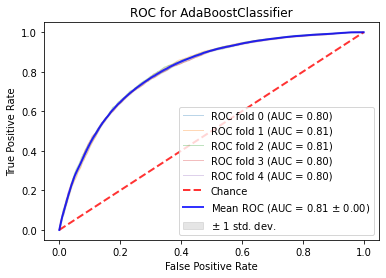


Scores for DecisionTreeClassifier
F1: 0.6600345921290872 +/- 0.0035034638716194607
P: 0.6602851612844755 +/- 0.0035219894243364953
R: 0.6601214349422604 +/- 0.003506294863316513
AUC: 0.6651501188398382 +/- 0.004012532004768604


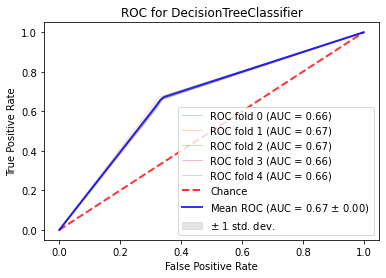


Scores for RandomForestClassifier
F1: 0.7322998404036638 +/- 0.003091496772843522
P: 0.7324138325171721 +/- 0.0031103319955579065
R: 0.7323253429782459 +/- 0.0030953520008100703
AUC: 0.8032100814378236 +/- 0.004840838737447968


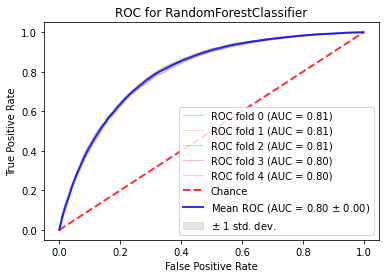

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Scores for LogisticRegression
F1: 0.6975096263261552 +/- 0.004381572345295135
P: 0.7007337319948299 +/- 0.004528651553068273
R: 0.6983910547449756 +/- 0.004396963691699677
AUC: 0.7535060985584217 +/- 0.004144253076200075


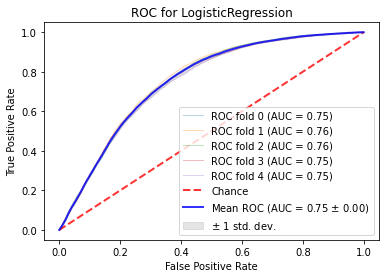

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report_TitleS = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report_TitleS = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report_TitleS = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report_TitleS = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report_TitleS = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(39)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 39)
(41860,)
(13954, 39)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 39)
(41860,)
(13954, 39)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 3ms/step - loss: 0.6468 - accuracy: 0.6314
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5830 - accuracy: 0.6941
Epoch 3/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.7220
Epoch 4/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.7370
Epoch 5/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.7417
Epoch 6/25
82/82 [==============================] - 0s 4ms/step - loss: 0.5295 - accuracy: 0.7438
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5269 - accuracy: 0.7460
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5278 - accuracy: 0.7429
Epoch 9/25

###  Psychology

In [ ]:
X = df_final[title_psychology_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
print(len(X.columns))
X.columns

197


Index(['title_emo_power', 'title_emo_plant', 'title_emo_pet',
       'title_emo_college', 'title_emo_anonymity', 'title_emo_play',
       'title_emo_banking', 'title_emo_wedding', 'title_emo_sports',
       'title_emo_white_collar_job',
       ...
       'title_emo_sexual', 'title_subjectivity', 'title_emo_work',
       'title_emo_warmth', 'title_emo_timidity', 'title_emo_payment',
       'title_emo_horror', 'title_emo_programming', 'title_emo_farming',
       'title_emo_dance'],
      dtype='object', length=197)


Scores for AdaBoostClassifier
F1: 0.7241080066182864 +/- 0.004049203687778785
P: 0.7295953816948262 +/- 0.0044642784489865904
R: 0.725373126087892 +/- 0.004078309469417263
AUC: 0.8114411848784324 +/- 0.004151820939639321


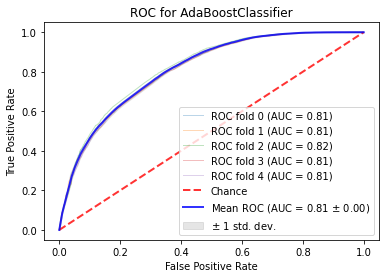


Scores for DecisionTreeClassifier
F1: 0.7162892266162413 +/- 0.0017651523668494938
P: 0.7164359734137473 +/- 0.0017248704294547802
R: 0.7163254480077803 +/- 0.0017548347824481313
AUC: 0.7249644868730258 +/- 0.0016708094536085985


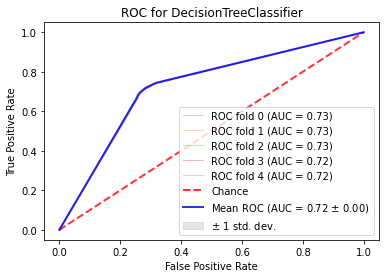


Scores for RandomForestClassifier
F1: 0.7817089015801918 +/- 0.0052110274510089845
P: 0.7824537782432113 +/- 0.0053415395036889605
R: 0.7818286675546242 +/- 0.005227093478462681
AUC: 0.8646470638832342 +/- 0.0031124818495646515


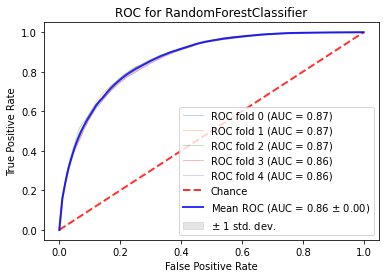

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.703355113801998 +/- 0.003987725397782519
P: 0.7100103329541241 +/- 0.00407518683949387
R: 0.7050917817535066 +/- 0.003968432171302344
AUC: 0.7801877728052569 +/- 0.005562380348475425


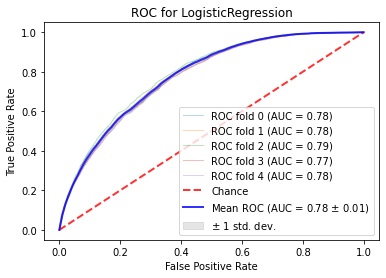

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report_TitleP = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report_TitleP = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report_TitleP = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report_TitleP = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(197)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 197)
(41860,)
(13954, 197)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 197)
(41860,)
(13954, 197)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.6351
Epoch 2/25
82/82 [==============================] - 0s 5ms/step - loss: 0.5532 - accuracy: 0.7054
Epoch 3/25
82/82 [==============================] - 0s 5ms/step - loss: 0.5380 - accuracy: 0.7162
Epoch 4/25
82/82 [==============================] - 0s 5ms/step - loss: 0.5283 - accuracy: 0.7234
Epoch 5/25
82/82 [==============================] - 0s 4ms/step - loss: 0.5168 - accuracy: 0.7327
Epoch 6/25
82/82 [==============================] - 0s 5ms/step - loss: 0.5058 - accuracy: 0.7396
Epoch 7/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4950 - accuracy: 0.7483
Epoch 8/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.7555
Epoch 

### Complexity

In [ ]:
X = df_final[title_complexity_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_avg_sent_len', 'title_avg_word_len', 'title_flesch_kincaidgrade',
       'title_flesch_readability', 'title_gunning_fog'],
      dtype='object')


Scores for AdaBoostClassifier
F1: 0.6930318849564526 +/- 0.00459744612175971
P: 0.6986968514281966 +/- 0.004502190271690479
R: 0.6946112048665911 +/- 0.00445676324661039
AUC: 0.7519425151257733 +/- 0.002859981264042517


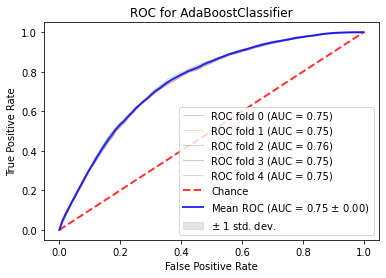


Scores for DecisionTreeClassifier
F1: 0.6567841143613318 +/- 0.004006407434551606
P: 0.6568964837492117 +/- 0.003944654427171023
R: 0.6568243196785737 +/- 0.003983831005749715
AUC: 0.6849370036376313 +/- 0.0029223254385557715


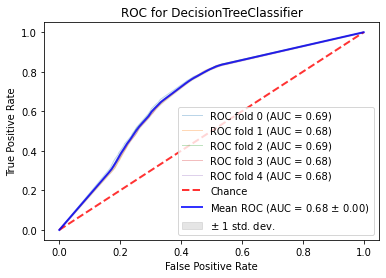


Scores for RandomForestClassifier
F1: 0.6744256262514279 +/- 0.0024717371271759363
P: 0.6752510259679646 +/- 0.0024989951768966913
R: 0.6746872594745017 +/- 0.0024745284730512927
AUC: 0.7306408278149338 +/- 0.002361559742297075


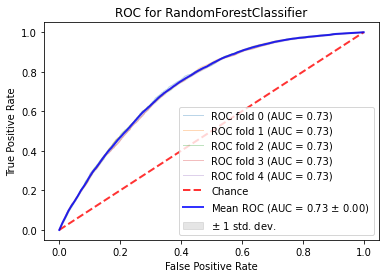


Scores for LogisticRegression
F1: 0.6577104110284365 +/- 0.0034614621282432452
P: 0.6594328198607836 +/- 0.003510421825722798
R: 0.6583118165095515 +/- 0.0034631312312023645
AUC: 0.6783857185352491 +/- 0.004293451544502445


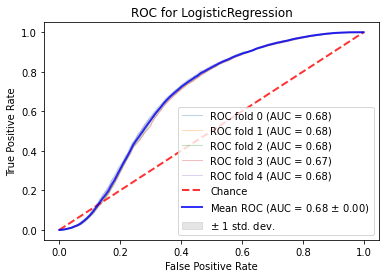

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report_titleC = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report_titleC = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report_titleC = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report_titleC = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(5)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 5)
(41860,)
(13954, 5)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 5)
(41860,)
(13954, 5)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 2s 3ms/step - loss: 0.6745 - accuracy: 0.6176
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6584
Epoch 3/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6751
Epoch 4/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.6815
Epoch 5/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5868 - accuracy: 0.6906
Epoch 6/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5847 - accuracy: 0.6924
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5834 - accuracy: 0.6927
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5829 - accuracy: 0.6929
Epoch 9/25
82/

### All features

In [ ]:
X = df_final[title_columns]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_emo_power', 'title_emo_plant', 'title_emo_pet',
       'title_emo_college', 'title_RBS', 'title_emo_anonymity',
       'title_emo_play', 'title_emo_wedding', 'title_emo_banking',
       'title_emo_sports',
       ...
       'title_subjectivity', 'title_emo_work', 'title_emo_warmth',
       'title_emo_timidity', 'title_emo_payment', 'title_emo_horror',
       'title_emo_programming', 'title_emo_farming', 'title_emo_dance',
       'title_VBN'],
      dtype='object', length=241)


Scores for AdaBoostClassifier
F1: 0.779497072532733 +/- 0.005379672973547898
P: 0.7824739616156383 +/- 0.005361523948221916
R: 0.779983425106848 +/- 0.005357693014431417
AUC: 0.8597122965608925 +/- 0.004290705166715029


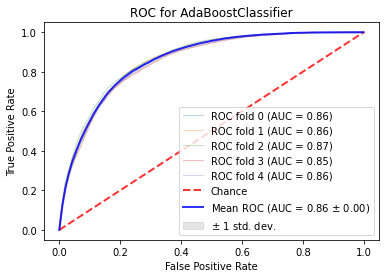


Scores for DecisionTreeClassifier
F1: 0.742532224862374 +/- 0.0016864218407689846
P: 0.7425584050270126 +/- 0.0016738159030689345
R: 0.7425378505962577 +/- 0.0016837661566147441
AUC: 0.74252092867054 +/- 0.0016853703823265875


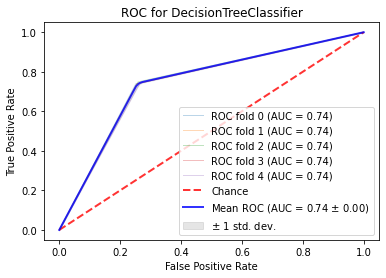


Scores for RandomForestClassifier
F1: 0.8226291091582831 +/- 0.00454284107802095
P: 0.824236148163482 +/- 0.004602751393951022
R: 0.8228223432487163 +/- 0.004542162593460609
AUC: 0.9020954108104116 +/- 0.0027879334011635904


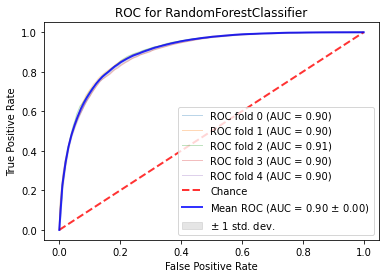

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.7705582092145626 +/- 0.0042754046594797035
P: 0.7731519054075506 +/- 0.004531176951606817
R: 0.771007261482646 +/- 0.0043055295658022226
AUC: 0.8469693513651775 +/- 0.004538966689398508


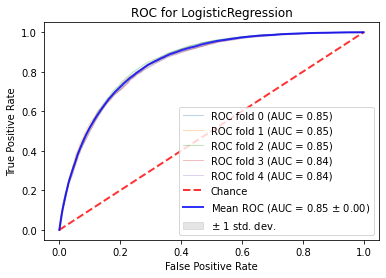

In [ ]:
adab = AdaBoostClassifier(random_state = 42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier( random_state = 42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(241)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 241)
(41860,)
(13954, 241)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 241)
(41860,)
(13954, 241)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.6873
Epoch 2/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4967 - accuracy: 0.7546
Epoch 3/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4622 - accuracy: 0.7822
Epoch 4/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4365 - accuracy: 0.7985
Epoch 5/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4176 - accuracy: 0.8103
Epoch 6/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4060 - accuracy: 0.8176
Epoch 7/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3930 - accuracy: 0.8253
Epoch 8/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3828 - accuracy: 0.8314
Epoch 

## Body

### Stylistic

In [ ]:
X = df_final[body_stylistic_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['body_WP$', 'body_VBP', 'body_UH', 'body_sent_count', 'body_PRP',
       'body_SYM', 'body_RBR', 'body_''', 'body_RBS', 'body_``', 'body_RB',
       'body_CC', 'body_$', 'body_VBG', 'body_NNPS', 'body_NNS', 'body_VBZ',
       'body_NN', 'body_RP', 'body_IN', 'body_VBD', 'body_EX', 'body_JJS',
       'body_MD', 'body_JJ', 'body_length', 'body_WP', 'body_CD', 'body_FW',
       'body_POS', 'body_VBN', 'body_TO', 'body_word_count', 'body_PDT',
       'body_VB', 'body_DT', 'body_WRB', 'body_WDT', 'body_NNP', 'body_PRP$',
       'body_JJR'],
      dtype='object')


Scores for AdaBoostClassifier
F1: 0.7569368455428948 +/- 0.003244942151673846
P: 0.7573429581636748 +/- 0.0032780205424165366
R: 0.7570142619964304 +/- 0.003249047638098263
AUC: 0.8350719451312353 +/- 0.003146881425771384


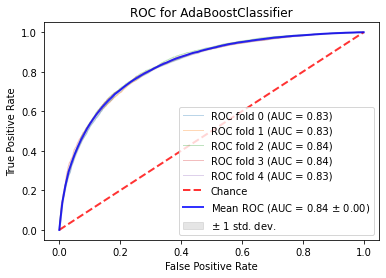


Scores for DecisionTreeClassifier
F1: 0.6994413798625472 +/- 0.0032622632744077574
P: 0.6994667674140603 +/- 0.0032862685525197038
R: 0.6994482964190258 +/- 0.003268730655078738
AUC: 0.6994296839127305 +/- 0.00326873065507876


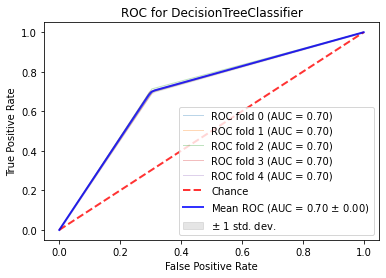


Scores for RandomForestClassifier
F1: 0.7867890342977496 +/- 0.004646282767522815
P: 0.7868065407787459 +/- 0.004649533933940253
R: 0.7867918009682618 +/- 0.004646772893056558
AUC: 0.8687733799272558 +/- 0.0035591308524838064


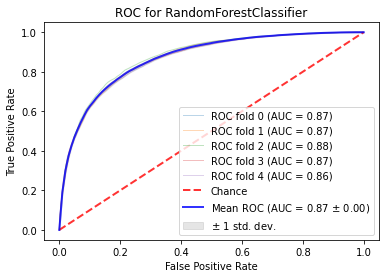


Scores for LogisticRegression
F1: 0.7371227903663546 +/- 0.006342507355642079
P: 0.7387073240607919 +/- 0.0060811394681043835
R: 0.737467238457039 +/- 0.006273387612375371
AUC: 0.8122412103940131 +/- 0.00446200971114268


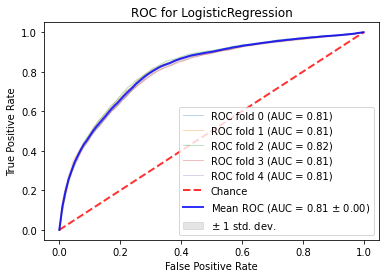

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(41)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 41)
(41860,)
(13954, 41)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 41)
(41860,)
(13954, 41)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 4ms/step - loss: 0.6543 - accuracy: 0.6547
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5644 - accuracy: 0.7311
Epoch 3/25
82/82 [==============================] - 0s 4ms/step - loss: 0.5301 - accuracy: 0.7510
Epoch 4/25
82/82 [==============================] - 0s 4ms/step - loss: 0.5115 - accuracy: 0.7595
Epoch 5/25
82/82 [==============================] - 0s 4ms/step - loss: 0.5047 - accuracy: 0.7621
Epoch 6/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4993 - accuracy: 0.7665
Epoch 7/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4971 - accuracy: 0.7657
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.7687
Epoch 9/25

### Psychology

In [ ]:
X = df_final[body_psychology_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['body_emo_exotic', 'body_emo_suffering', 'body_emo_pride',
       'body_emo_order', 'body_emo_terrorism', 'body_emo_government',
       'body_emo_ancient', 'body_emo_crime', 'body_emo_noise',
       'body_emo_movement',
       ...
       'body_emo_rural', 'body_emo_banking', 'body_emo_help', 'body_emo_plant',
       'body_emo_phone', 'body_emo_air_travel', 'body_emo_occupation',
       'body_emo_religion', 'body_emo_prison', 'body_emo_neglect'],
      dtype='object', length=196)


Scores for AdaBoostClassifier
F1: 0.766051138241288 +/- 0.002226767604190897
P: 0.7663115987707944 +/- 0.0021878071072615394
R: 0.7660982157112757 +/- 0.0022182210267439797
AUC: 0.8460468118170352 +/- 0.0027501038940372416


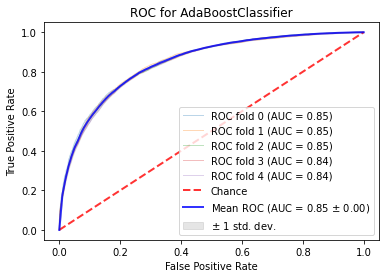


Scores for DecisionTreeClassifier
F1: 0.6930179112069157 +/- 0.003973988669360697
P: 0.6930746734659273 +/- 0.003987925409321702
R: 0.6930340220578716 +/- 0.003977737719932731
AUC: 0.6930207262548056 +/- 0.003977737719932847


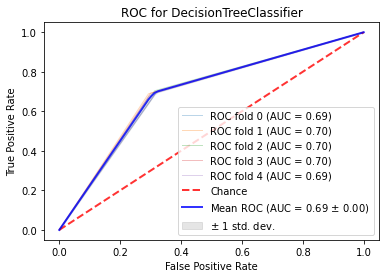


Scores for RandomForestClassifier
F1: 0.8074034594084972 +/- 0.002483209490524139
P: 0.807479730131927 +/- 0.002404852566394476
R: 0.8074141285652663 +/- 0.0024721391283556906
AUC: 0.8864191641529818 +/- 0.002917229225934198


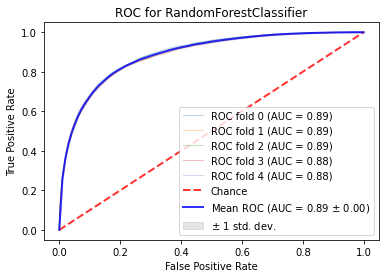


Scores for LogisticRegression
F1: 0.7737318890092677 +/- 0.0018354322165628758
P: 0.7738282891340953 +/- 0.0017832477679120796
R: 0.7737484520822973 +/- 0.0018264063221840703
AUC: 0.8505380135695882 +/- 0.001228482378280601


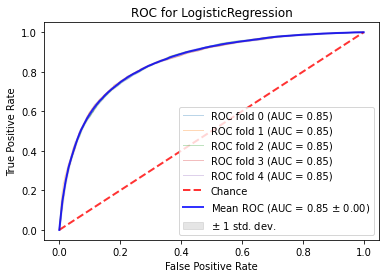

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(196)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 196)
(41860,)
(13954, 196)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 196)
(41860,)
(13954, 196)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 5ms/step - loss: 0.5743 - accuracy: 0.7183
Epoch 2/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.7684
Epoch 3/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4611 - accuracy: 0.7861
Epoch 4/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.7974
Epoch 5/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4278 - accuracy: 0.8052
Epoch 6/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4126 - accuracy: 0.8143
Epoch 7/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4000 - accuracy: 0.8207
Epoch 8/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3898 - accuracy: 0.8282
Epoch 

### Complexity

In [ ]:
X = df_final[body_complexity_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['body_avg_sent_len', 'body_avg_word_len', 'body_flesch_kincaidgrade',
       'body_flesch_readability', 'body_gunning_fog', 'body_TTR'],
      dtype='object')


Scores for AdaBoostClassifier
F1: 0.680092173950529 +/- 0.002174915011058953
P: 0.6809967330250535 +/- 0.002695757495408177
R: 0.6803667572278906 +/- 0.00230369124944734
AUC: 0.7358837324689996 +/- 0.005103114190693602


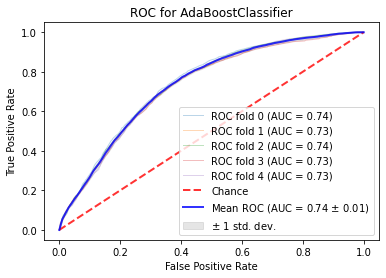


Scores for DecisionTreeClassifier
F1: 0.6285693768937983 +/- 0.006088940635484866
P: 0.6286122890234145 +/- 0.006058446687848046
R: 0.6285879703562485 +/- 0.006075299111668003
AUC: 0.6285758685746117 +/- 0.006075299111667971


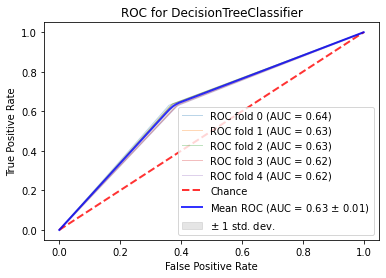


Scores for RandomForestClassifier
F1: 0.6966423515013158 +/- 0.0045883622304319594
P: 0.697199037020186 +/- 0.0046661776270552685
R: 0.6967964194430213 +/- 0.004603888869194958
AUC: 0.7673473362013943 +/- 0.005283205994622841


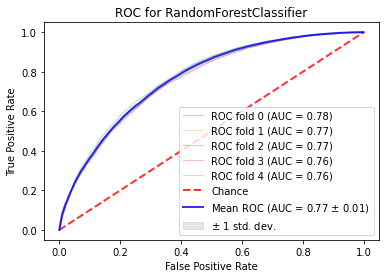


Scores for LogisticRegression
F1: 0.6346486716316834 +/- 0.0033106024947525225
P: 0.6349919002393157 +/- 0.0033331373893549653
R: 0.6347870689897025 +/- 0.003316304961446776
AUC: 0.6747613066450954 +/- 0.005347143018215388


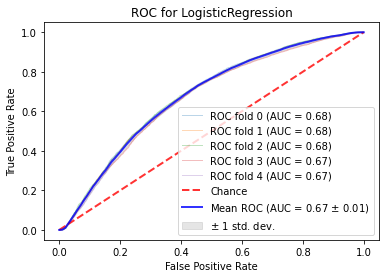

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(6)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 6)
(41860,)
(13954, 6)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 6)
(41860,)
(13954, 6)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 3ms/step - loss: 0.6895 - accuracy: 0.5354
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5715
Epoch 3/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6085
Epoch 4/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6525
Epoch 5/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6623
Epoch 6/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6710
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6748
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6779
Epoch 9/25
82/

### All features

In [ ]:
X = df_final[body_columns]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['body_emo_exotic', 'body_emo_suffering', 'body_emo_pride',
       'body_sent_count', 'body_emo_order', 'body_emo_terrorism',
       'body_emo_government', 'body_emo_ancient', 'body_emo_crime',
       'body_emo_noise',
       ...
       'body_emo_plant', 'body_emo_phone', 'body_VB', 'body_emo_air_travel',
       'body_flesch_readability', 'body_emo_occupation', 'body_emo_religion',
       'body_emo_prison', 'body_PRP$', 'body_emo_neglect'],
      dtype='object', length=243)


Scores for AdaBoostClassifier
F1: 0.8022133790168626 +/- 0.0017249174724081892
P: 0.8025013620910947 +/- 0.0017026999482494902
R: 0.8022539106970334 +/- 0.0017206154563942947
AUC: 0.8826742817268268 +/- 0.0021075803985463153


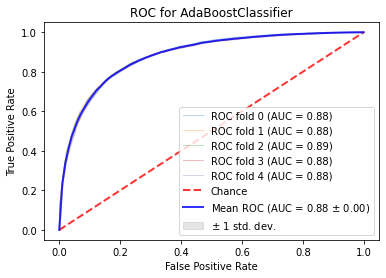


Scores for DecisionTreeClassifier
F1: 0.7367623106584713 +/- 0.003666637960021677
P: 0.7367906964201854 +/- 0.003672786596672473
R: 0.7367683330304212 +/- 0.003667731209490574
AUC: 0.7367452428046839 +/- 0.0036677312094905395


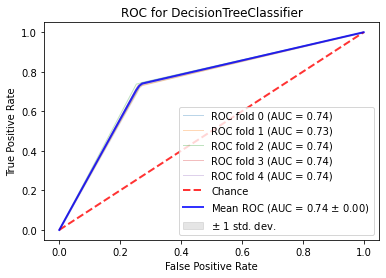


Scores for RandomForestClassifier
F1: 0.8367403270701225 +/- 0.002456935244280656
P: 0.8367699813317389 +/- 0.00247194340679997
R: 0.8367434880244182 +/- 0.002458407614021677
AUC: 0.915273322115999 +/- 0.002717318349939531


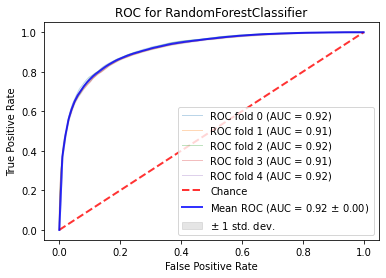

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.8172724585698733 +/- 0.003298383561116237
P: 0.81738055801279 +/- 0.003302253408540932
R: 0.8172860573742449 +/- 0.003298659542132272
AUC: 0.8911161206938499 +/- 0.002334691353691362


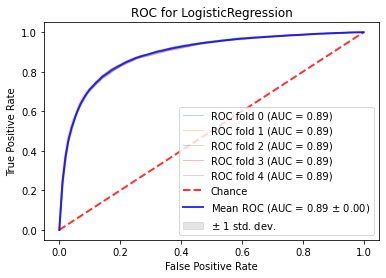

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(243)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 243)
(41860,)
(13954, 243)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 243)
(41860,)
(13954, 243)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 5ms/step - loss: 0.5561 - accuracy: 0.7351
Epoch 2/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.8038
Epoch 3/25
82/82 [==============================] - 0s 5ms/step - loss: 0.4045 - accuracy: 0.8230
Epoch 4/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3808 - accuracy: 0.8348
Epoch 5/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3624 - accuracy: 0.8424
Epoch 6/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3468 - accuracy: 0.8497
Epoch 7/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3341 - accuracy: 0.8558
Epoch 8/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3218 - accuracy: 0.8623
Epoch 

## Title +  Body

### Stylistic

In [ ]:
import itertools

In [ ]:
all_stylistic_features = list(itertools.chain(title_stylistic_features,body_stylistic_features))

In [ ]:
X = df_final[all_stylistic_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_WP$', 'title_VBZ', 'title_EX', 'title_RBS', 'title_JJ',
       'title_RB', 'title_JJR', 'title_UH', 'title_TO', 'title_POS',
       'title_NNPS', 'title_PDT', 'title_WP', 'title_VBP', 'title_NNP',
       'title_WRB', 'title_length', 'title_IN', 'title_FW', 'title_NNS',
       'title_VB', 'title_JJS', 'title_sent_count', 'title_CD', 'title_MD',
       'title_SYM', 'title_NN', 'title_PRP$', 'title_PRP', 'title_RP',
       'title_CC', 'title_''', 'title_RBR', 'title_WDT', 'title_VBD',
       'title_DT', 'title_VBN', 'title_VBG', 'title_word_count', 'body_WP$',
       'body_VBP', 'body_UH', 'body_sent_count', 'body_PRP', 'body_SYM',
       'body_RBR', 'body_''', 'body_RBS', 'body_``', 'body_RB', 'body_CC',
       'body_$', 'body_VBG', 'body_NNPS', 'body_NNS', 'body_VBZ', 'body_NN',
       'body_RP', 'body_IN', 'body_VBD', 'body_EX', 'body_JJS', 'body_MD',
       'body_JJ', 'body_length', 'body_WP', 'body_CD', 'body_FW', 'body_POS',
       'body_VBN', 'body_TO', 'body_word_cou


Scores for AdaBoostClassifier
F1: 0.809641633232071 +/- 0.004205888569402986
P: 0.810405245664214 +/- 0.004246218822392592
R: 0.809743091082113 +/- 0.004207059101576796
AUC: 0.8874769202446288 +/- 0.0026681904712327347


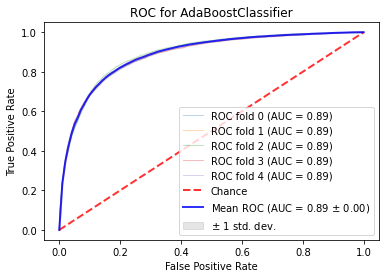


Scores for DecisionTreeClassifier
F1: 0.7640317094499103 +/- 0.003628129373165914
P: 0.7640647185271197 +/- 0.00362120265853843
R: 0.7640379419835085 +/- 0.003626760307800559
AUC: 0.7640150393776234 +/- 0.0036267603078005794


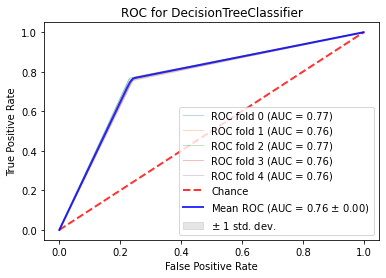


Scores for RandomForestClassifier
F1: 0.8455013163532314 +/- 0.00361100029485395
P: 0.8455333857010334 +/- 0.003588255208797521
R: 0.8455045561696475 +/- 0.003608754010775767
AUC: 0.9176038273483311 +/- 0.003484183964031034


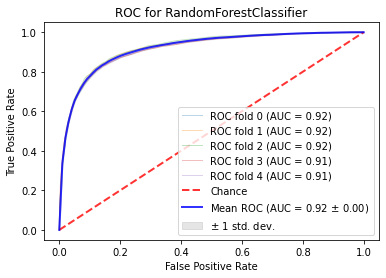

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.7876594992649725 +/- 0.00427944470856191
P: 0.7884203344107237 +/- 0.004425165175966407
R: 0.7877771526223583 +/- 0.0042973464400231625
AUC: 0.8575511031564292 +/- 0.0036825490454520534


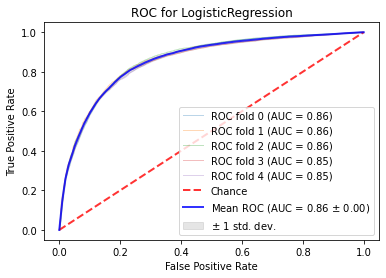

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(80)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 80)
(41860,)
(13954, 80)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 80)
(41860,)
(13954, 80)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 4ms/step - loss: 0.6162 - accuracy: 0.6730
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7723
Epoch 3/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4467 - accuracy: 0.8033
Epoch 4/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4250 - accuracy: 0.8153
Epoch 5/25
82/82 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8231
Epoch 6/25
82/82 [==============================] - 0s 4ms/step - loss: 0.3980 - accuracy: 0.8291
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.3901 - accuracy: 0.8341
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8358
Epoch 9/25

### Psychology

In [ ]:
all_psychology_features = list(itertools.chain(title_psychology_features,body_psychology_features))

In [ ]:
X = df_final[all_psychology_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_emo_power', 'title_emo_plant', 'title_emo_pet',
       'title_emo_college', 'title_emo_anonymity', 'title_emo_play',
       'title_emo_banking', 'title_emo_wedding', 'title_emo_sports',
       'title_emo_white_collar_job',
       ...
       'body_emo_rural', 'body_emo_banking', 'body_emo_help', 'body_emo_plant',
       'body_emo_phone', 'body_emo_air_travel', 'body_emo_occupation',
       'body_emo_religion', 'body_emo_prison', 'body_emo_neglect'],
      dtype='object', length=393)


Scores for AdaBoostClassifier
F1: 0.7950427779464123 +/- 0.003976108254929455
P: 0.7958226727758708 +/- 0.0037649812879293654
R: 0.7951587162540459 +/- 0.003941068576019381
AUC: 0.8787647993313371 +/- 0.0036535341308580405


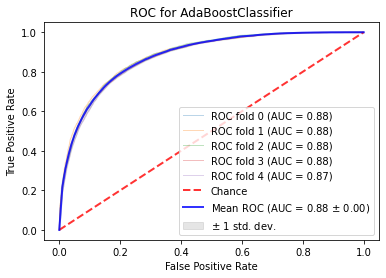


Scores for DecisionTreeClassifier
F1: 0.7302264196897441 +/- 0.001041204448215465
P: 0.7302375827359406 +/- 0.0010453483861774604
R: 0.7302289091739126 +/- 0.0010421214023366827
AUC: 0.7302075024281758 +/- 0.0010421214023366855


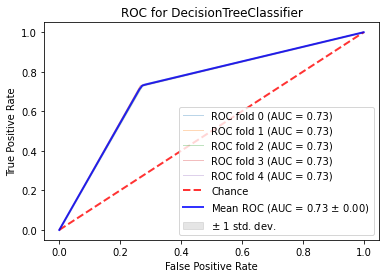


Scores for RandomForestClassifier
F1: 0.8264388153032876 +/- 0.0035812315299423958
P: 0.826764410983888 +/- 0.0035290102806688753
R: 0.8264772907978271 +/- 0.0035733381907306844
AUC: 0.9098191683572838 +/- 0.0027046547802221372


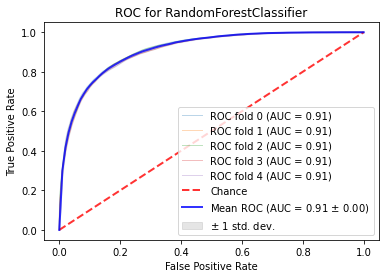

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.7965095517718135 +/- 0.0021517220149798438
P: 0.7970765038676376 +/- 0.002230906389434226
R: 0.7965923629789894 +/- 0.002159588316037206
AUC: 0.8777115356470465 +/- 0.0016475633541993301


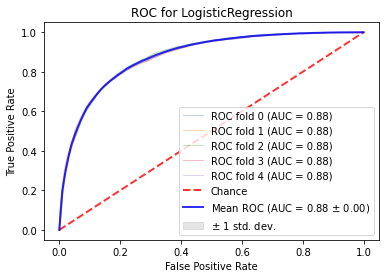

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(393)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 393)
(41860,)
(13954, 393)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 393)
(41860,)
(13954, 393)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 6ms/step - loss: 0.5506 - accuracy: 0.7281
Epoch 2/25
82/82 [==============================] - 0s 6ms/step - loss: 0.4414 - accuracy: 0.7932
Epoch 3/25
82/82 [==============================] - 0s 6ms/step - loss: 0.4174 - accuracy: 0.8084
Epoch 4/25
82/82 [==============================] - 0s 6ms/step - loss: 0.3972 - accuracy: 0.8202
Epoch 5/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3787 - accuracy: 0.8302
Epoch 6/25
82/82 [==============================] - 0s 5ms/step - loss: 0.3624 - accuracy: 0.8420
Epoch 7/25
82/82 [==============================] - 0s 6ms/step - loss: 0.3436 - accuracy: 0.8516
Epoch 8/25
82/82 [==============================] - 0s 6ms/step - loss: 0.3291 - accuracy: 0.8596
Epoch 

### Complexity  

In [ ]:
all_complexity_features = list(itertools.chain(title_complexity_features,body_complexity_features))

In [ ]:
X = df_final[all_complexity_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_avg_sent_len', 'title_avg_word_len', 'title_flesch_kincaidgrade',
       'title_flesch_readability', 'title_gunning_fog', 'body_avg_sent_len',
       'body_avg_word_len', 'body_flesch_kincaidgrade',
       'body_flesch_readability', 'body_gunning_fog', 'body_TTR'],
      dtype='object')


Scores for AdaBoostClassifier
F1: 0.7523194131743169 +/- 0.004650671060891795
P: 0.753874534282325 +/- 0.0045583598563129855
R: 0.7526251541497804 +/- 0.0046186779740106125
AUC: 0.8189493224212145 +/- 0.005251439422198943


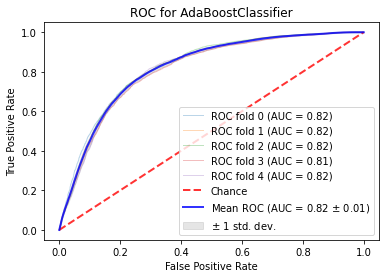


Scores for DecisionTreeClassifier
F1: 0.7084759010249865 +/- 0.0031127484145060404
P: 0.7085535799933936 +/- 0.0030919919479367097
R: 0.7084961157368974 +/- 0.0031070034224488135
AUC: 0.7084800917549688 +/- 0.0031070034224487406


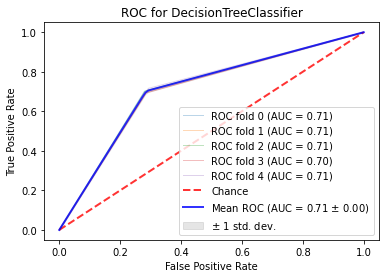


Scores for RandomForestClassifier
F1: 0.7932902367915368 +/- 0.004452837253194536
P: 0.7938009914182869 +/- 0.004327812009560227
R: 0.7933673528018458 +/- 0.004430877867333673
AUC: 0.8677969566697127 +/- 0.004511216621021437


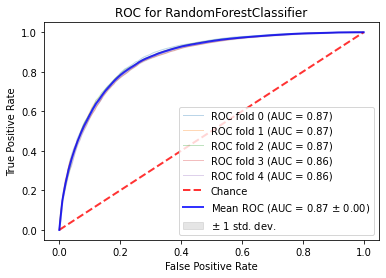


Scores for LogisticRegression
F1: 0.6881436518952972 +/- 0.0038597338669001807
P: 0.6892446754997273 +/- 0.00377574438074563
R: 0.68846571238304 +/- 0.003821917528090136
AUC: 0.7279282127554831 +/- 0.005402725381544314


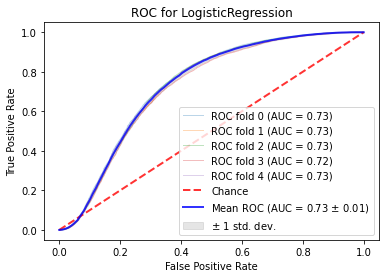

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(11)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 11)
(41860,)
(13954, 11)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 11)
(41860,)
(13954, 11)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.6067
Epoch 2/25
82/82 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.6807
Epoch 3/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.7075
Epoch 4/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5501 - accuracy: 0.7330
Epoch 5/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5330 - accuracy: 0.7439
Epoch 6/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5256 - accuracy: 0.7504
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5148 - accuracy: 0.7585
Epoch 8/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.7592
Epoch 9/25

### All features

In [ ]:
all_features = list(itertools.chain(title_columns,body_columns))

In [ ]:
X = df_final[all_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
X.columns

Index(['title_emo_power', 'title_emo_plant', 'title_emo_pet',
       'title_emo_college', 'title_RBS', 'title_emo_anonymity',
       'title_emo_play', 'title_emo_wedding', 'title_emo_banking',
       'title_emo_sports',
       ...
       'body_emo_plant', 'body_emo_phone', 'body_VB', 'body_emo_air_travel',
       'body_flesch_readability', 'body_emo_occupation', 'body_emo_religion',
       'body_emo_prison', 'body_PRP$', 'body_emo_neglect'],
      dtype='object', length=484)


Scores for AdaBoostClassifier
F1: 0.8432656938446976 +/- 0.0017046162144295554
P: 0.8441360168672659 +/- 0.0017169179548628861
R: 0.8433545996740873 +/- 0.0017028468194012106
AUC: 0.9191240724639343 +/- 0.0027920457131883417


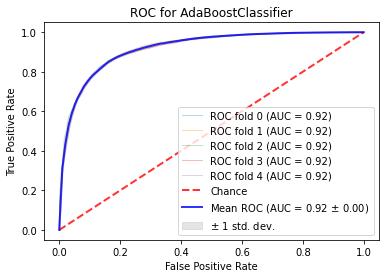


Scores for DecisionTreeClassifier
F1: 0.7945286868046574 +/- 0.003689958438040944
P: 0.7945508370795753 +/- 0.0036867002949564896
R: 0.794532086041273 +/- 0.003689242196260448
AUC: 0.7945070776561682 +/- 0.0036892421962604533


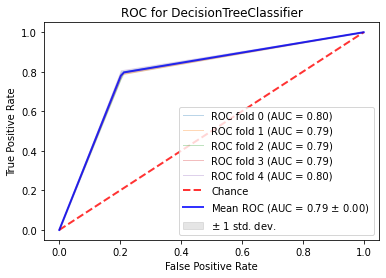


Scores for RandomForestClassifier
F1: 0.8735211035195046 +/- 0.003348321338524461
P: 0.8735887471924274 +/- 0.0033378547524716092
R: 0.8735265450913425 +/- 0.0033475417348073533
AUC: 0.9449547577566727 +/- 0.0033113275431696327


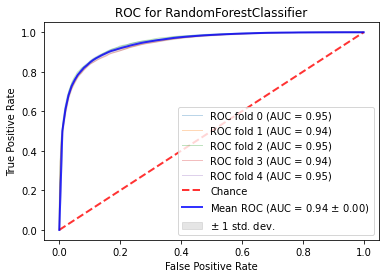

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Scores for LogisticRegression
F1: 0.8558178012010128 +/- 0.0030590815959930127
P: 0.8560896396877531 +/- 0.00313814522975738
R: 0.8558426819355814 +/- 0.0030653612663856414
AUC: 0.9270843469031314 +/- 0.0025553919144183975


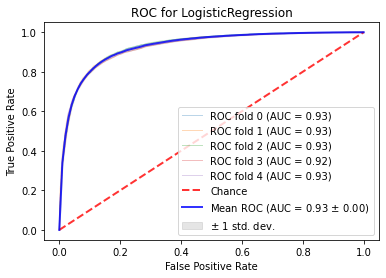

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab_report = model_evaluate(X,y,adab)

dtree = DecisionTreeClassifier(random_state = 42)
dtree_report = model_evaluate(X,y,dtree)

rf = RandomForestClassifier(random_state=42)
rf_report = model_evaluate(X,y,rf)

# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb_report = model_evaluate(X,y,nb)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr_report = model_evaluate(X,y,lr)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

model = init_nn(484)

model.fit(X_train, y_train, epochs=25, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred_bool = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_bool))
print("AUROC:",metrics.roc_auc_score(y_test,y_pred))

(41860, 484)
(41860,)
(13954, 484)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
(41860, 484)
(41860,)
(13954, 484)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64
Epoch 1/25
82/82 [==============================] - 1s 6ms/step - loss: 0.5111 - accuracy: 0.7625
Epoch 2/25
82/82 [==============================] - 1s 7ms/step - loss: 0.3768 - accuracy: 0.8342
Epoch 3/25
82/82 [==============================] - 0s 6ms/step - loss: 0.3348 - accuracy: 0.8578
Epoch 4/25
82/82 [==============================] - 1s 6ms/step - loss: 0.3048 - accuracy: 0.8737
Epoch 5/25
82/82 [==============================] - 1s 6ms/step - loss: 0.2811 - accuracy: 0.8855
Epoch 6/25
82/82 [==============================] - 1s 6ms/step - loss: 0.2621 - accuracy: 0.8941
Epoch 7/25
82/82 [==============================] - 1s 6ms/step - loss: 0.2474 - accuracy: 0.9007
Epoch 8/25
82/82 [==============================] - 1s 6ms/step - loss: 0.2309 - accuracy: 0.9070
Epoch 

## Explain best network: Neural network

In [ ]:
X = df_final[all_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Value counts")
print(y_train.value_counts())

(41860, 484)
(41860,)
(13954, 484)
(13954,)
Value counts
1    20930
0    20930
Name: label, dtype: int64


In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=512)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

Epoch 1/20
82/82 [==============================] - 1s 7ms/step - loss: 0.5161 - accuracy: 0.7548
Epoch 2/20
82/82 [==============================] - 1s 8ms/step - loss: 0.3743 - accuracy: 0.8380
Epoch 3/20
82/82 [==============================] - 1s 7ms/step - loss: 0.3347 - accuracy: 0.8582
Epoch 4/20
82/82 [==============================] - 1s 8ms/step - loss: 0.3046 - accuracy: 0.8724
Epoch 5/20
82/82 [==============================] - 1s 7ms/step - loss: 0.2819 - accuracy: 0.8834
Epoch 6/20
82/82 [==============================] - 1s 7ms/step - loss: 0.2625 - accuracy: 0.8927
Epoch 7/20
82/82 [==============================] - 1s 7ms/step - loss: 0.2456 - accuracy: 0.9010
Epoch 8/20
82/82 [==============================] - 1s 8ms/step - loss: 0.2290 - accuracy: 0.9085
Epoch 9/20
82/82 [==============================] - 1s 7ms/step - loss: 0.2158 - accuracy: 0.9151
Epoch 10/20
82/82 [==============================] - 1s 8ms/step - loss: 0.2022 - accuracy: 0.9213
Epoch 11/20
82/82 [

In [ ]:
def prob(data):
    #print(data.shape)
    y_pred=model.predict(data).reshape(-1, 1)
    y_pred =(y_pred>0.5)
    #print(np.array(list(zip(1-y_pred.reshape(data.shape[0]),y_pred.reshape(data.shape[0])))))
    return np.hstack((1-y_pred,y_pred))

In [ ]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train[list(X_train.columns)].values,  
mode='classification', training_labels=y_train, feature_names=list(X_train.columns))

In [ ]:
i = 42
exp = explainer.explain_instance(X_test.loc[i,X.columns].values, prob, num_features=5)
exp.show_in_notebook(show_table=True)

# Explainability for best model

In [ ]:
all_features = list(itertools.chain(title_columns,body_columns))

In [ ]:
X = df_final[all_features]
y = df_final.label.astype(int)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scale= MinMaxScaler()
X = pd.DataFrame(scale.fit_transform(X), columns = X.columns)
print(y.value_counts())

1    27907
0    27907
Name: label, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0, stratify = y)

In [ ]:
adab = AdaBoostClassifier()
adab.fit(X_train, y_train)
metrics.accuracy_score(y_test,adab.predict(X_test))

0.8406191772968324

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns, class_names =  ['Fake','Real'])

In [ ]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[i].to_numpy(), adab.predict_proba, num_features=10)

display(Markdown(df.iloc[i].title))
display(Markdown(df.iloc[i].body))
print('Actual label', df.iloc[i].label)
exp.show_in_notebook(show_table=True)

podesta in leaked e mail   dump those emails 

date  2015 03 08 15 49 subject  fwd  lanny davis we got to zap lanny out of our universe  cannot believe he committed her to a private review of her hard drive on tv  on march 4  2015  two days after the e mail in which podesta wrote  “we are going to have to dump all those emails so better to do so sooner than later ” the house select committee on benghazi subpoenaed clinton demanding “any and all documents and communications in your possession  and or sent from or received by the email adresses  sic  ‘  ’ ‘  ’ or any other email adress  sic  or communications device used by you or another on your behalf  referring or relating to” the committee’s investigation into benghazi  the subpoena specifically demanded all such “communications” “for the time period of january 1  2011 through december 31  2012 ” clinton — in a possible move to buy more time to “dump all those emails” — falsely claimed that she had not been subpoenaed  the committee responded by making the subpoena public  committee chairman trey gowdy wrote  “i would not make this  subpoena  public now  but after secretary clinton falsely claimed the committee did not subpoena her  i have no choice in order to correct the inaccuracy ” the press release   dated july 18  2015 says  in part  “the committee has issued several subpoenas  but i have not sought to make them public   said committee chairman trey gowdy  “i would not make this one public now  but after secretary clinton falsely claimed the committee did not subpoena her  i have no choice in order to correct the inaccuracy  the committee immediately subpoenaed clinton personally after learning the full extent of her unusual email arrangement with herself  and would have done so earlier if the state department or clinton had been forthcoming that state did not maintain custody of her records and only secretary clinton herself had her records when congress first requested them ” “the fact remains  despite when this subpoena was issued  secretary clinton had a statutory duty to preserve records from her entire time in office  and she had a legal duty to cooperate with and tell the truth to congressional investigators requesting her records going back to september of 2012  yet despite direct congressional inquiry  she refused to inform the public of her unusual email arrangement  this information only came to light because of a select committee request  not a voluntary decision to turn over records almost two years after leaving office  records which always should have been in state’s custody    moreover  the timing of the secretary s decision to delete and attempt to permanently destroy emails is curious at best  the secretary left office in february of 2013  by her own admission she did not delete or destroy emails until the fall of 2014  well after this committee had been actively engaged in securing her emails from the department of state  for 20 months  it was not too burdensome or cumbersome for the secretary to house records on her personal server but mysteriously in the fall of 2014 she decided to delete and attempt to permanently destroy those same records   the press release contains a link to the actual subpoena   as the press release makes clear  “by her own admission” hillary clinton “did not delete or destroy emails until the fall of 2014 ” what is left unclear is this  if those e mails had already been deleted  as she claimed   then what e mails was podesta referring to when he said they were “going to have to dump” them “sooner” rather than “later”  and if the e mails had been deleted in 2014  why did hillary have her server wiped using bleachbit before turning it over to investigators  it is hopeful that two things will happen following this most recent disclosure  the first is that this will find its way into the newly reopened investigation into clinton’s use of the private  unsecured server  the second is that wikileaks will release additional pieces of the puzzle to clarify what is still unclear  with less than a week left until the election  it is likely to be an exciting few days  photo of john podesta  ap images please review our comment policy before posting a comment 
thank you for joining the discussion at the new american  we value our readers and encourage their participation  but in order to ensure a positive experience for our readership  we have a few guidelines for commenting on articles  if your post does not follow our policy  it will be deleted  
no profanity  racial slurs  direct threats  or threatening language  
no product advertisements  
please post comments in english  
please keep your comments on topic with the article  if you wish to comment on another subject  you may search for a relevant article and join or start a discussion there 

Actual label 0
